## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
import joblib
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

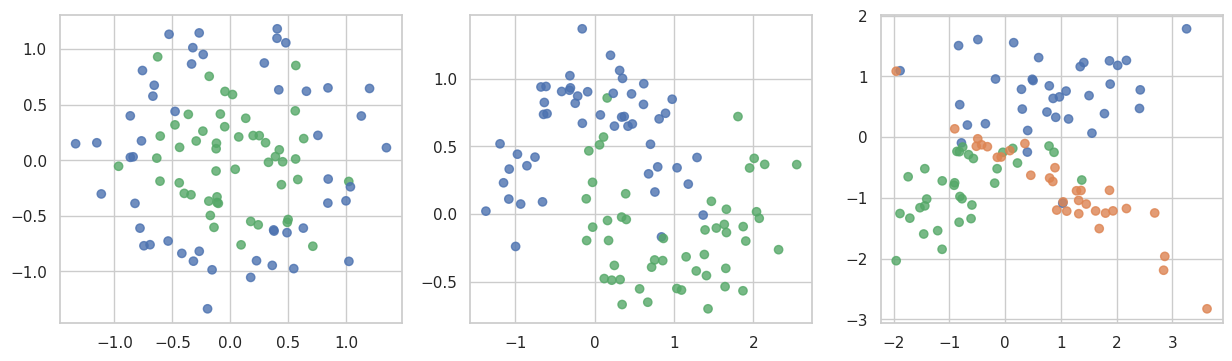

In [ ]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

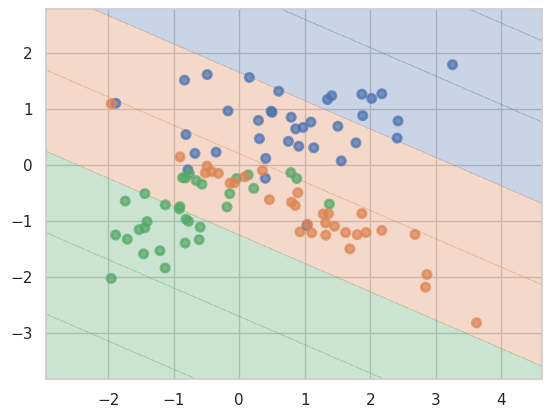

In [ ]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)


dataset 1:
  Accuracy на обучающей выборке: 1.000
  Accuracy на тестовой выборке: 0.833
  Разница: 0.167

dataset 2:
  Accuracy на обучающей выборке: 1.000
  Accuracy на тестовой выборке: 0.800
  Разница: 0.200

dataset 3:
  Accuracy на обучающей выборке: 1.000
  Accuracy на тестовой выборке: 0.767
  Разница: 0.233


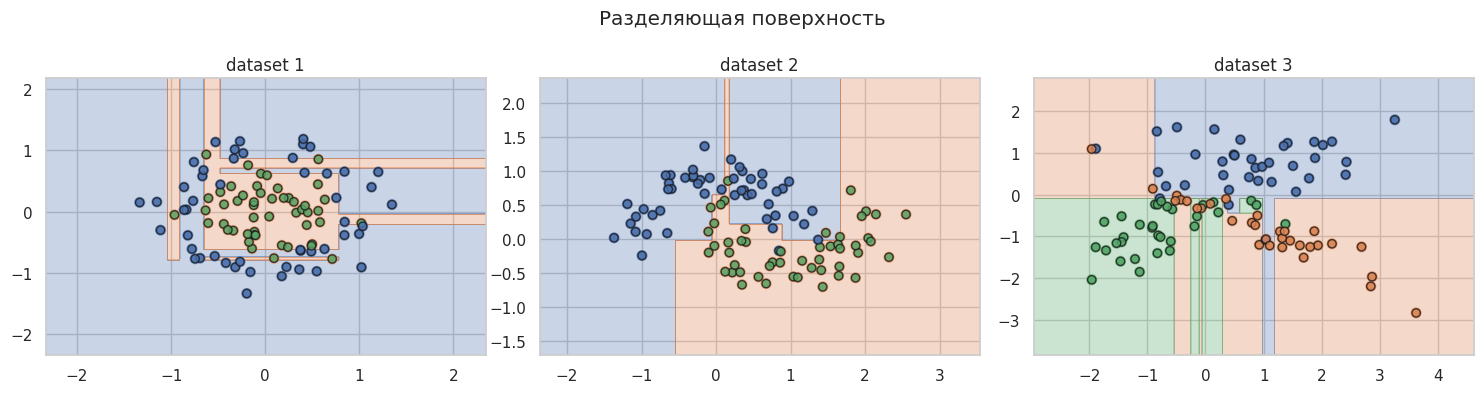

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

def plot_decision_surfaces_and_accuracy():

    plt.figure(figsize=(15, 4))

    for i, (X, y) in enumerate(datasets):
        # фиксированное разбиение на train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=15)

        # обучение решающего дерева с параметрами по умолчанию
        tree = DecisionTreeClassifier(random_state=15)
        tree.fit(X_train, y_train)

        # разделяющая поверхность
        plt.subplot(1, 3, i + 1)
        plot_surface(tree, X, y)

        # точки из всего датасета для наглядности
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.8, edgecolors='k', linewidths=1)
        plt.suptitle('Разделяющая поверхность')
        plt.title(f'dataset {i+1}')

        # accuracy на обучающей и тестовой выборках
        y_train_pred = tree.predict(X_train)
        y_test_pred = tree.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # результаты
        print(f"\ndataset {i+1}:")
        print(f"  Accuracy на обучающей выборке: {train_accuracy:.3f}")
        print(f"  Accuracy на тестовой выборке: {test_accuracy:.3f}")
        print(f"  Разница: {train_accuracy - test_accuracy:.3f}")

    plt.tight_layout()
    plt.show()

plot_decision_surfaces_and_accuracy()

__Ответ:__

Переобучение значительно для всех трех датасетов:
1. Accuracy на обучающей выборке достигает 1.0 (идеальное соответствие)
2. Accuracy на тестовой выборке существенно ниже (для random_state=15: 0.833; 0.8; 0.767)

Деревья строят слишком сложные разделяющие поверхности, которые 'запоминают' обучающие данные

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


dataset: 1
№  | max_depth | min_samples_leaf | Train Acc  | Test Acc   | Difference  
------------------------------------------------------------------------
1  | None      | 1                | 1.000      | 0.833      | 0.167       
2  | 5         | 1                | 0.929      | 0.867      | 0.062       
3  | 3         | 1                | 0.843      | 0.800      | 0.043       
4  | None      | 5                | 0.900      | 0.900      | 0.000       
5  | None      | 20               | 0.700      | 0.700      | 0.000       
6  | 3         | 5                | 0.843      | 0.800      | 0.043       
________________________________________________________________________


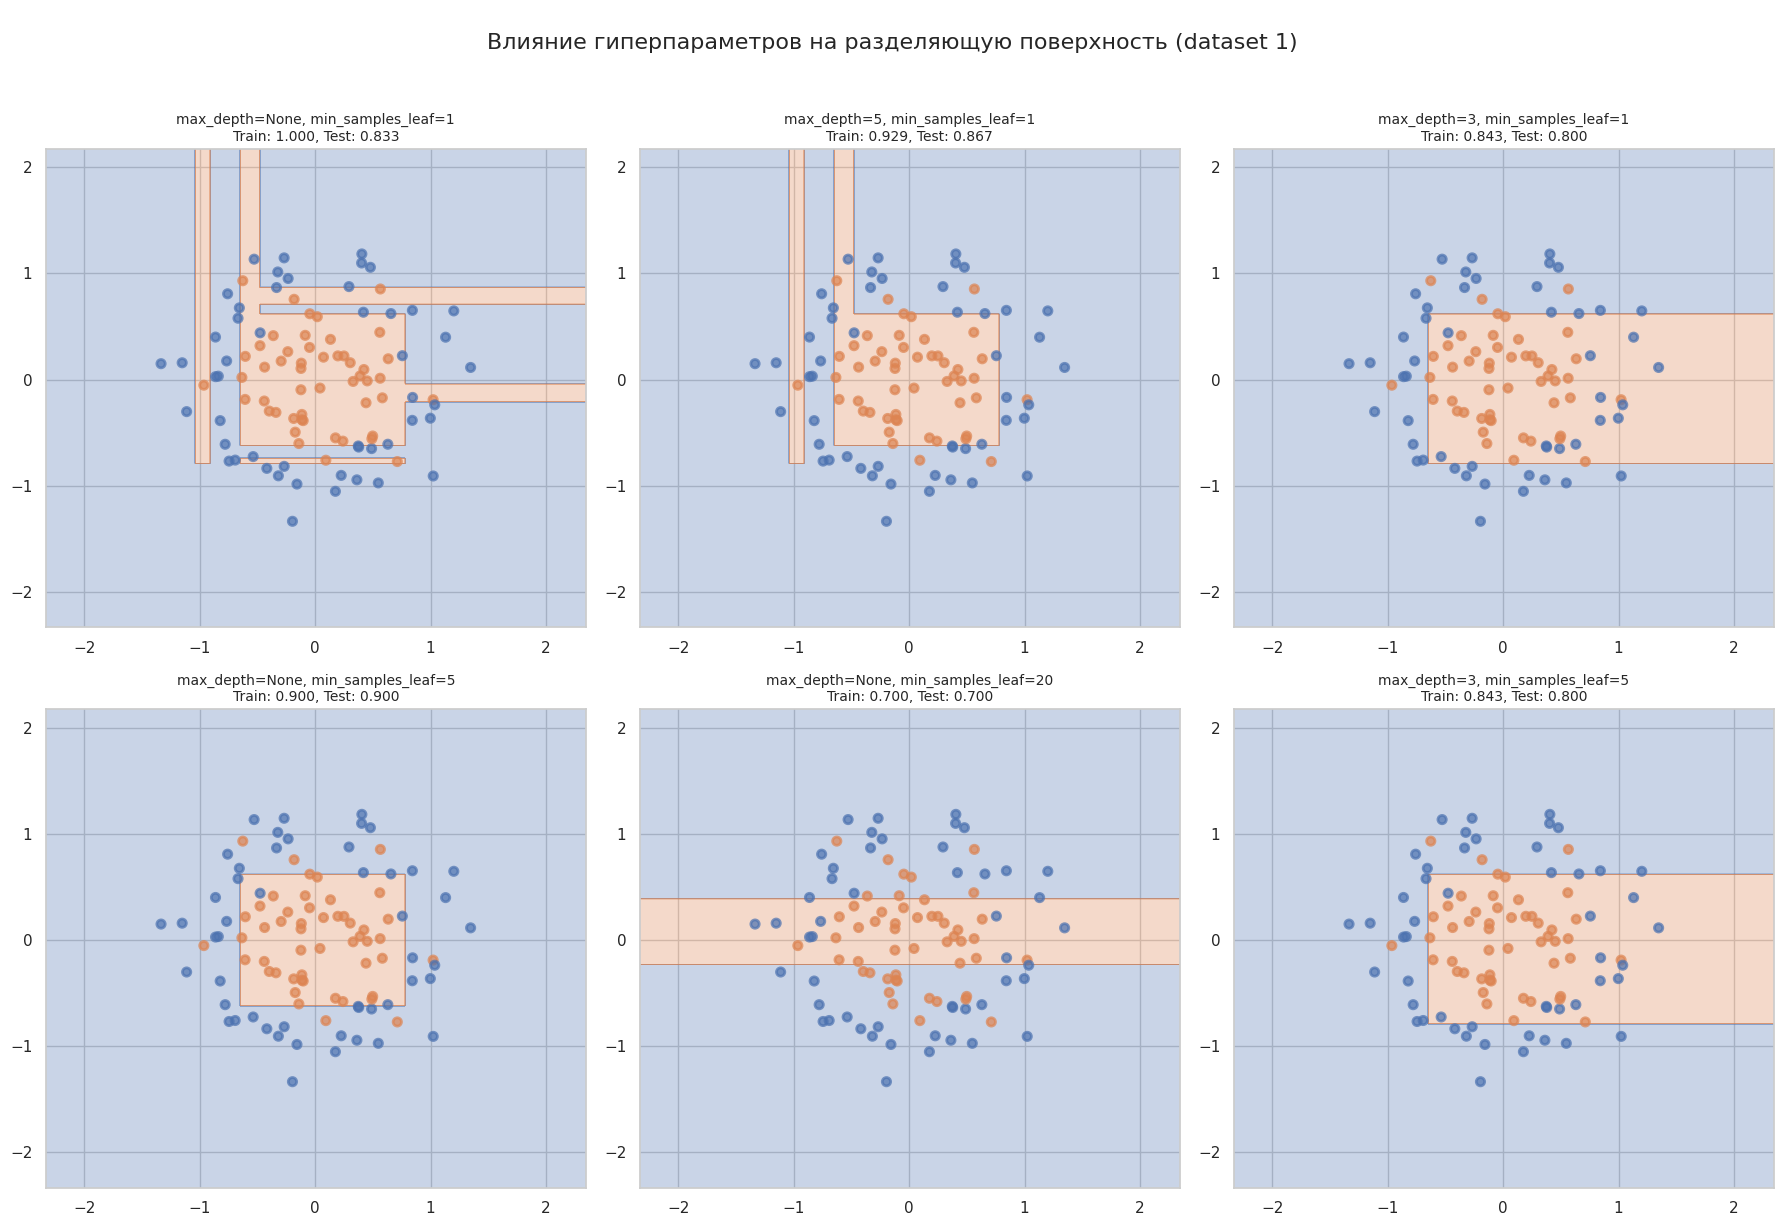


dataset: 2
№  | max_depth | min_samples_leaf | Train Acc  | Test Acc   | Difference  
------------------------------------------------------------------------
1  | None      | 1                | 1.000      | 0.800      | 0.200       
2  | 5         | 1                | 0.971      | 0.833      | 0.138       
3  | 3         | 1                | 0.929      | 0.833      | 0.095       
4  | None      | 5                | 0.943      | 0.900      | 0.043       
5  | None      | 20               | 0.857      | 0.767      | 0.090       
6  | 3         | 5                | 0.900      | 0.900      | 0.000       
________________________________________________________________________


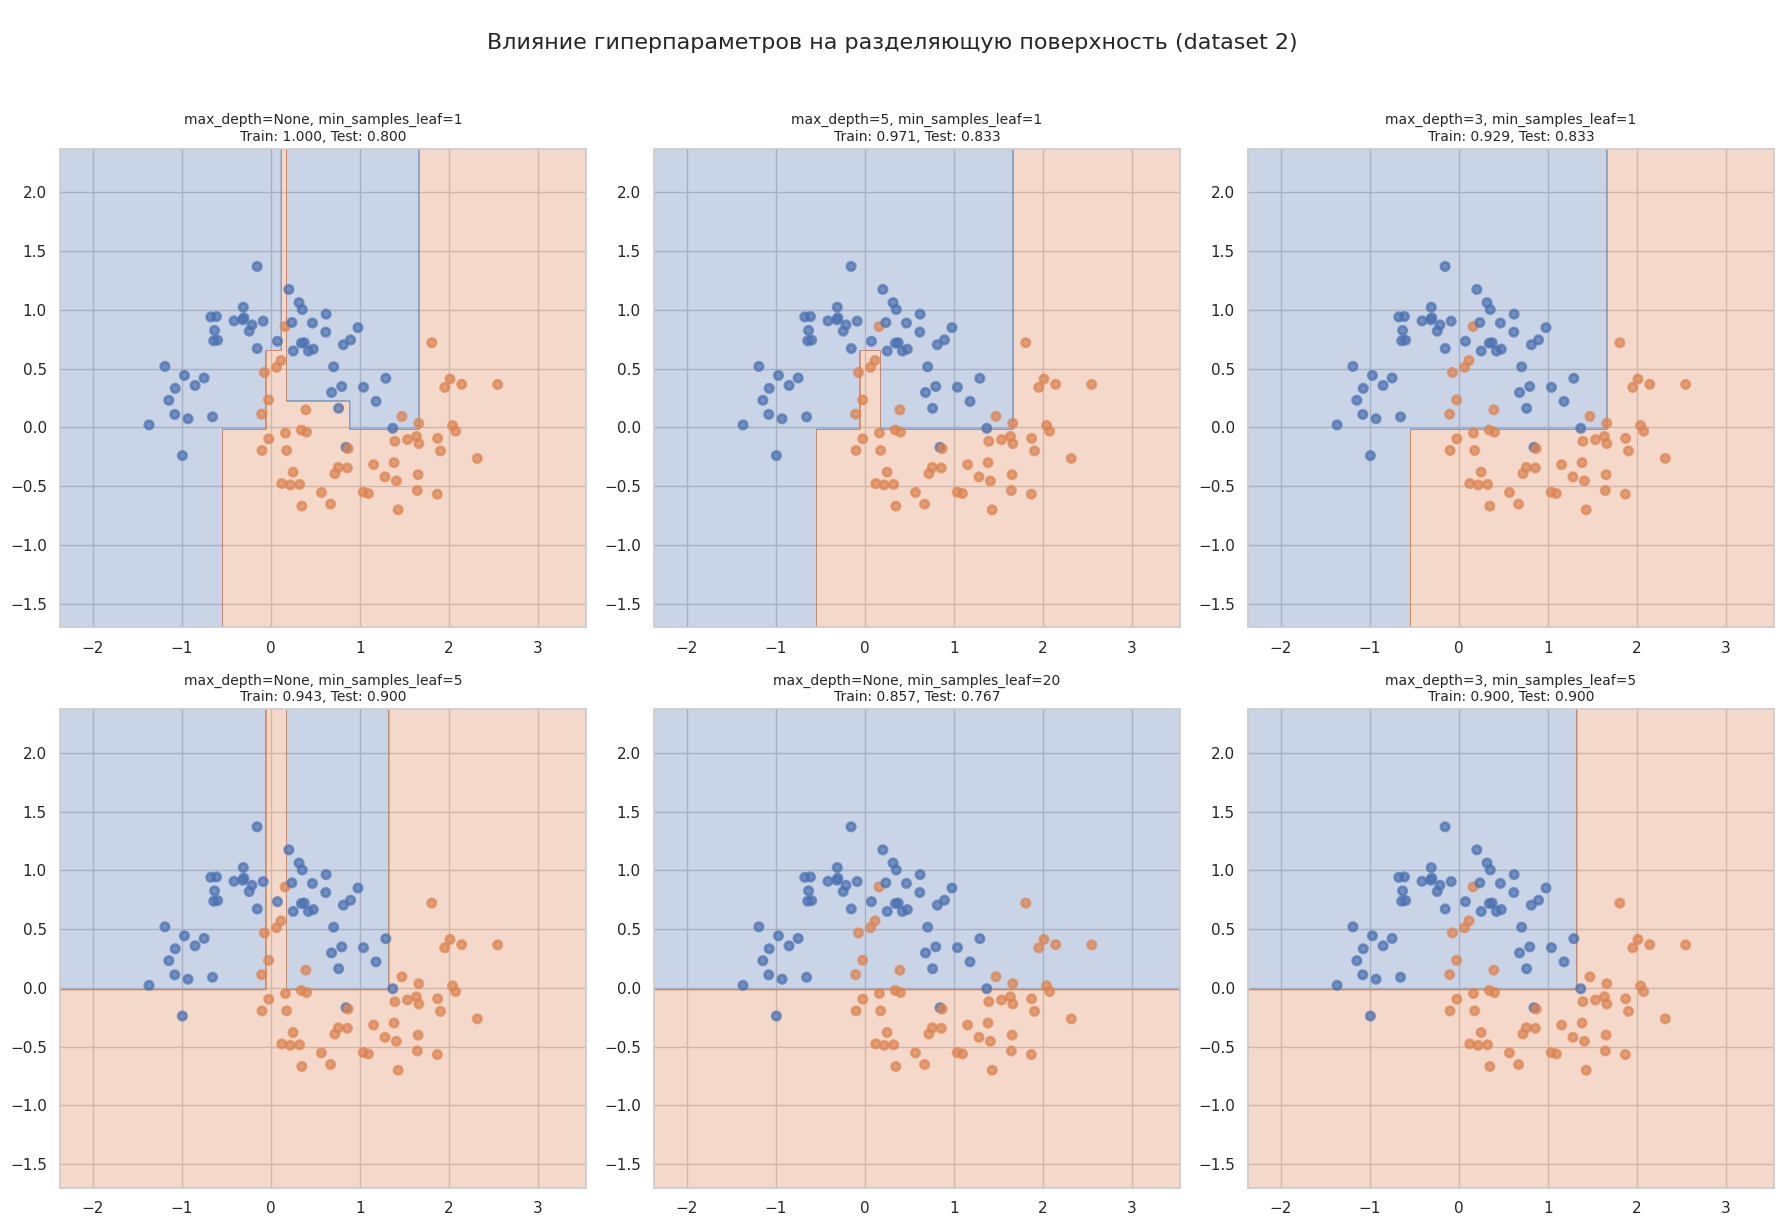


dataset: 3
№  | max_depth | min_samples_leaf | Train Acc  | Test Acc   | Difference  
------------------------------------------------------------------------
1  | None      | 1                | 1.000      | 0.767      | 0.233       
2  | 5         | 1                | 0.929      | 0.833      | 0.095       
3  | 3         | 1                | 0.871      | 0.900      | -0.029      
4  | None      | 5                | 0.914      | 0.833      | 0.081       
5  | None      | 20               | 0.843      | 0.867      | -0.024      
6  | 3         | 5                | 0.857      | 0.900      | -0.043      
________________________________________________________________________


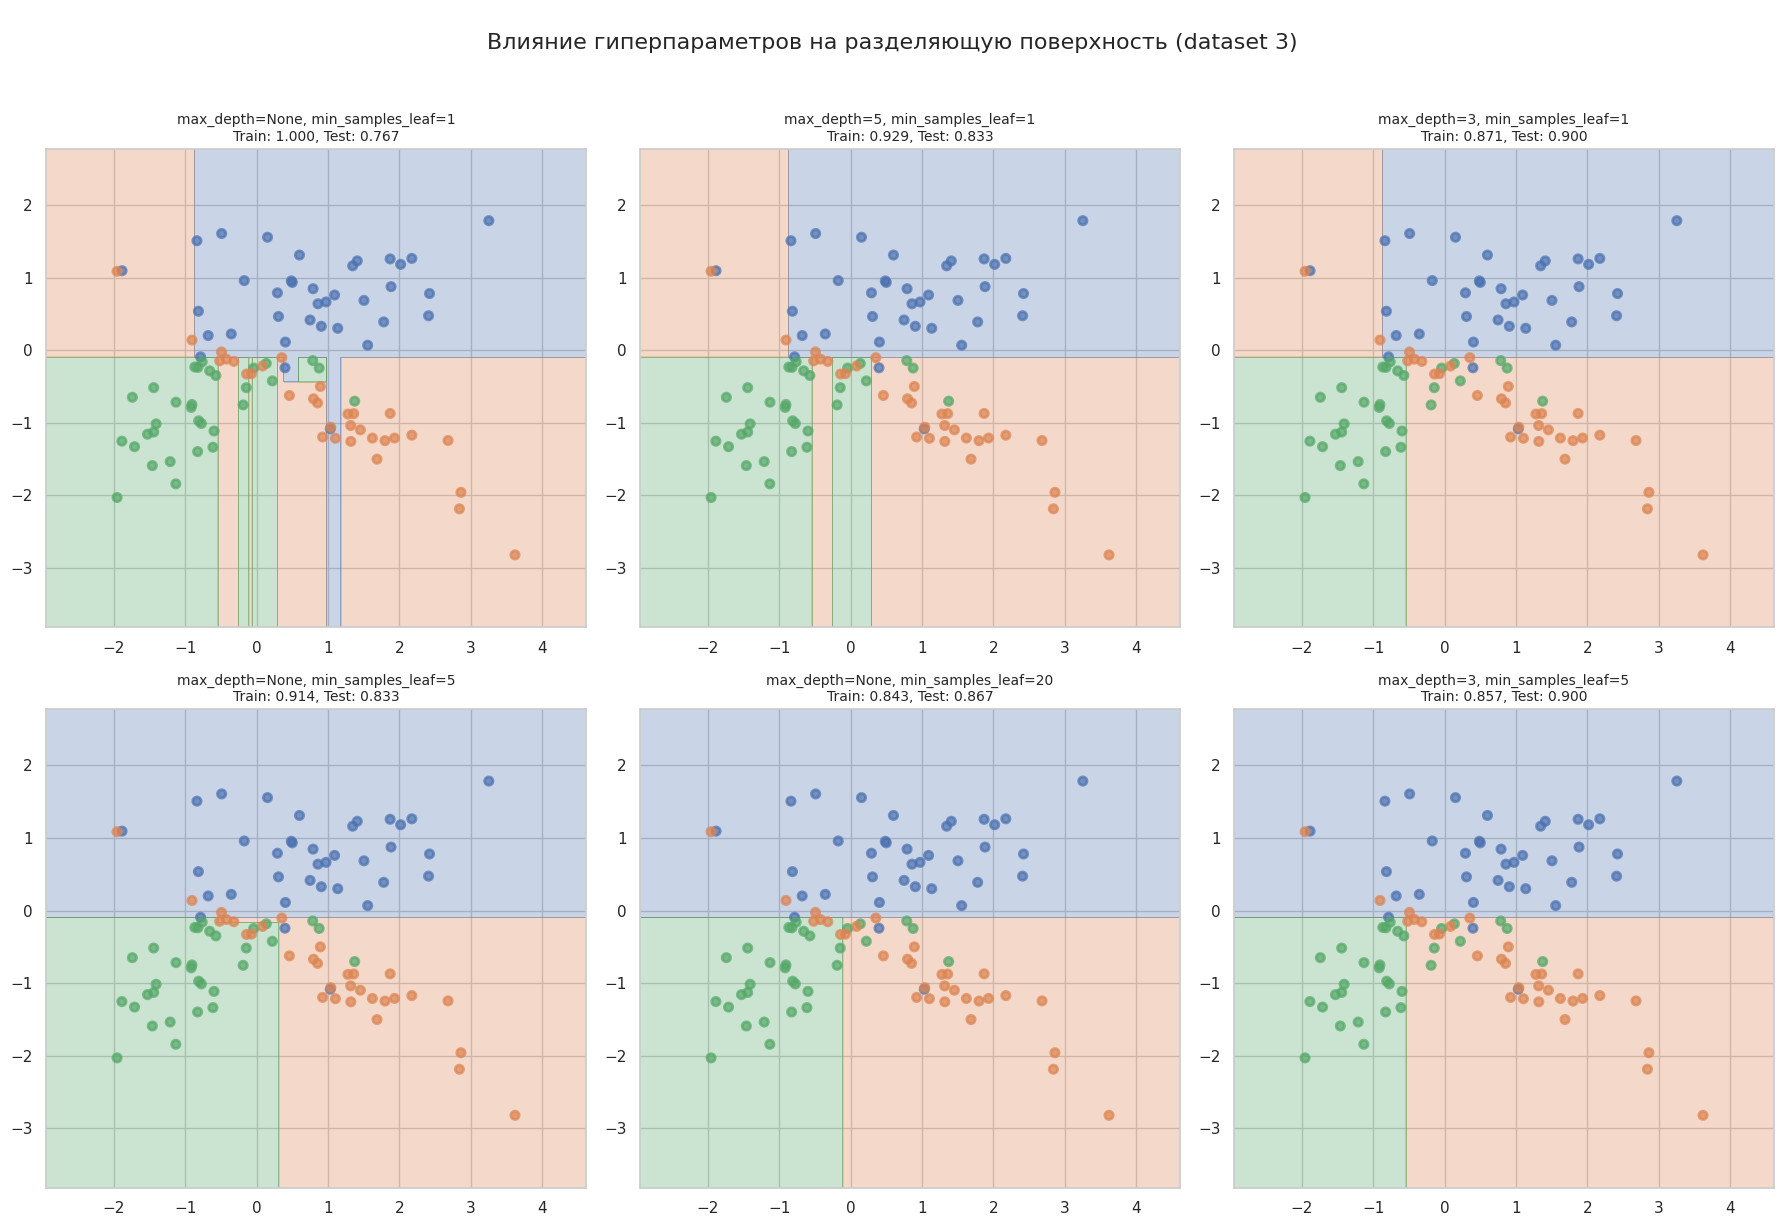

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

def analyze_hyperparameters(param_grid=None):

    # параметры для перебора
    if param_grid is None:
        param_grid = [
            {'max_depth': None, 'min_samples_leaf': 1},      # Без ограничений (как в 1.1)
            {'max_depth': 5, 'min_samples_leaf': 1},         # Ограничение по глубине
            {'max_depth': 3, 'min_samples_leaf': 1},         # Сильное ограничение по глубине
            {'max_depth': None, 'min_samples_leaf': 5},      # Ограничение по листьям
            {'max_depth': None, 'min_samples_leaf': 20},     # Сильное ограничение по листьям
            {'max_depth': 3, 'min_samples_leaf': 5},         # Комбинированное ограничение
        ]

    for dataset_idx, (X, y) in enumerate(datasets):

        # фиксированное разбиение на train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=15)

        fig = plt.figure(figsize=(18, 12))
        results = []

        for i, params in enumerate(param_grid):
            # модель с текущими параметрами
            tree = DecisionTreeClassifier(
                max_depth=params['max_depth'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=15)

            tree.fit(X_train, y_train)

            # accuracy
            y_train_pred = tree.predict(X_train)
            y_test_pred = tree.predict(X_test)

            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            diff = train_accuracy - test_accuracy

            # результаты для таблицы
            results.append({
                'max_depth': params['max_depth'],
                'min_samples_leaf': params['min_samples_leaf'],
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'difference': diff})

            # разделяющая поверхность
            ax = plt.subplot(2, 3, i + 1)
            plot_surface(tree, X, y)

            # заголовоки
            param_str = f"max_depth={params['max_depth']}, min_samples_leaf={params['min_samples_leaf']}"
            title = f"{param_str}\nTrain: {train_accuracy:.3f}, Test: {test_accuracy:.3f}"
            plt.title(title, fontsize=10)

        # сравнительная таблица
        print(f'\ndataset: {dataset_idx+1}')
        print("="*72)
        print(f"{'№':<2} | {'max_depth':<8} | {'min_samples_leaf':<15} | {'Train Acc':<10} | {'Test Acc':<10} | {'Difference':<12}")
        print("-"*72)

        for idx, result in enumerate(results):
            max_depth = str(result['max_depth']) if result['max_depth'] is not None else 'None'
            print(f"{idx+1:<2} | {max_depth:<9} | {result['min_samples_leaf']:<16} | "
                  f"{result['train_accuracy']:<10.3f} | {result['test_accuracy']:<10.3f} | "
                  f"{result['difference']:<12.3f}")
        print("_"*72)


        plt.suptitle(f'\nВлияние гиперпараметров на разделяющую поверхность (dataset {dataset_idx+1})',
                     fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

analyze_hyperparameters()

__Ответ:__


Гиперпараметры:
  - max_depth ограничивает глубину дерева - чем меньше глубина, тем меньше переобучение (но слишком малая глубина - недообучение (низкая accuracy на обеих выборках)
  - min_samples_leaf задает минимальное количество образцов в листе - уменьшает чувствительность к шуму данных (чем больше значение, тем более гладкие поверхности)
  - комбинирование параметров (глубина + листья) дает лучший контроль над переобучением

Особенности для разных датасетов:

dataset 1:
  - Нелинейная граница
  - Требует достаточно (но не слишком) глубоких деревьев для хорошей accuracy

dataset 2:
  - Нелинейная граница
  - Деревья средней глубины показывают лучший баланс (сильное ограничение приводит к недообучению)

dataset 3:
  - Линейно разделимые классы
  - Простые деревья хорошо справляются (регуляризация меньше влияет на итоговую accuracy, но показывает более точные результаты, чем параметры по умолчанию)


# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# загрузка данных
df = pd.read_csv('datasets/mushroom/agaricus-lepiota.data', header=None)

# LabelEncoder по всем столбцам
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

# разделение на признаки и целевую переменную
X = df_encoded.iloc[:, 1:].values  # все столбцы кроме первого
y = df_encoded.iloc[:, 0].values   # первый столбец - целевая переменная

# фиксированное разбиение на train/test (50%/50%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=15, stratify=y)

# обучение решающего дерева
clf = DecisionTreeClassifier(random_state=15)
clf.fit(X_train, y_train)

# предсказание
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# вычисление accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# вывод
print(f"Accuracy на обучающей выборке: {train_accuracy:.4f}")
print(f"Accuracy на тестовой выборке: {test_accuracy:.4f}")
print(f"Разница: {train_accuracy - test_accuracy:.4f}")
print(f"Глубина дерева: {clf.get_depth()}")
print(f"Количество листьев: {clf.get_n_leaves()}")

Accuracy на обучающей выборке: 1.0000
Accuracy на тестовой выборке: 1.0000
Разница: 0.0000
Глубина дерева: 7
Количество листьев: 18


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

def load_and_prepare_dataset(dataset_name):
    """ загружает и подготавливает датасет """
    try:
        if dataset_name == 'mushrooms':
            df = pd.read_csv('datasets/mushroom/agaricus-lepiota.data', header=None)
            X = df.iloc[:, 1:]  # признаки
            y = df.iloc[:, 0]   # целевая

        elif dataset_name == 'tic-tac-toe':
            df = pd.read_csv('datasets/tic-tac-toe/tic-tac-toe.data', header=None)
            X = df.iloc[:, :-1]
            y = df.iloc[:, -1]

        elif dataset_name == 'cars':
            df = pd.read_csv('datasets/cars/car.data', header=None)
            X = df.iloc[:, :-1]
            y = df.iloc[:, -1]
            y = y.apply(lambda x: 0 if x in ['unacc', 'acc'] else 1)

        elif dataset_name == 'nursery':
            df = pd.read_csv('datasets/nursery/nursery.data', header=None)
            X = df.iloc[:, :-1]
            y = df.iloc[:, -1]
            y = y.apply(lambda x: 0 if x in ['not_recom', 'recommend'] else 1)

        elif dataset_name == 'user-knowledge-modeling':
            df = pd.read_excel(
                'datasets/user-knowledge-modeling/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls',
                sheet_name='Training_Data',
                engine='xlrd')
            X = df.iloc[:, :5]
            y = df.iloc[:, 5]

        # кодирование признаков
        if dataset_name == 'user-knowledge-modeling':
            X_encoded = X.values.astype(float)
        else:
            X_encoded = X.apply(lambda col: LabelEncoder().fit_transform(col.astype(str))).values

        return X_encoded, y.values

    except Exception as e:
        print(f"Ошибка загрузки {dataset_name}: {str(e)}")
        return None, None

def evaluate_models(X, y, dataset_name):
    """ оценивает три алгоритма с кросс-валидацией """
    results = {}

    # 1. DecisionTree с ordinal encoding
    dt_ordinal = DecisionTreeClassifier(random_state=15)
    scores_ordinal = cross_val_score(dt_ordinal, X, y, cv=10,
                                     scoring=make_scorer(accuracy_score))
    results['DecisionTree (ordinal)'] = np.mean(scores_ordinal)

    # 2. DecisionTree с categorical encoding
    dt_categorical = DecisionTreeClassifier(random_state=15)
    scores_categorical = cross_val_score(dt_categorical, X, y, cv=10,
                                        scoring=make_scorer(accuracy_score))
    results['DecisionTree (categorical)'] = np.mean(scores_categorical)

    # 3. DecisionTree + OneHot encoding (только для категориальных датасетов)
    if dataset_name == 'user-knowledge-modeling':
        # для числовых данных OneHot не применяется
        results['DecisionTree + OneHot'] = np.nan
    else:
        onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_onehot = onehot.fit_transform(X)
        dt_onehot = DecisionTreeClassifier(random_state=15)
        scores_onehot = cross_val_score(dt_onehot, X_onehot, y, cv=10,
                                       scoring=make_scorer(accuracy_score))
        results['DecisionTree + OneHot'] = np.mean(scores_onehot)

    return results


# анализ влияния кодирования категориальных признаков на точность деревьев решений
datasets_list = ['mushrooms', 'tic-tac-toe', 'cars', 'nursery', 'user-knowledge-modeling']
results_df = pd.DataFrame(index=datasets_list,
                         columns=['DecisionTree (ordinal)',
                                 'DecisionTree (categorical)',
                                 'DecisionTree + OneHot'])
# вывод
print("_"*51  + '\n')
print("Анализ влияния кодирования категориальных признаков\nна точность деревьев решений")
print("_"*51)

for dataset in datasets_list:
    print(f"\ndataset: {dataset}")
    print("-"*32)

    X, y = load_and_prepare_dataset(dataset)

    if X is None or y is None:
        print("✗ Не загружен")
        continue

    y = LabelEncoder().fit_transform(y)
    results = evaluate_models(X, y, dataset)
    results_df.loc[dataset] = results

    print(f"  Образцы: {X.shape[0]}")
    print(f"  Признаки: {X.shape[1]}")
    print(f"  Классы: {len(np.unique(y))}")
    print(f"  Вещественные: {results['DecisionTree (ordinal)']:.4f}")
    print(f"  Категориальные: {results['DecisionTree (categorical)']:.4f}")
    if pd.notna(results['DecisionTree + OneHot']):
        print(f"  OneHot: {results['DecisionTree + OneHot']:.4f}")
    else:
        print(f"  OneHot: не применяется (признаки числовые)")

print("\n" + "_"*95 + '\n')
print("Результаты (accuracy, cv=10)")
print("_"*95 + '\n')
print(results_df.to_string(float_format=lambda x: f"{x:.4f}" if pd.notna(x) else "N/A"))
print("_"*95)

# # сохранение результатов в .csv (по желанию)
# results_df.to_csv('datasets/encoding_comparison_results.csv', index=True, float_format='%.4f')
# print(f"\nDataFrame сохранен в 'datasets/encoding_comparison_results.csv'")

___________________________________________________

Анализ влияния кодирования категориальных признаков
на точность деревьев решений
___________________________________________________

dataset: mushrooms
--------------------------------
  Образцы: 8124
  Признаки: 22
  Классы: 2
  Вещественные: 0.9567
  Категориальные: 0.9567
  OneHot: 0.9683

dataset: tic-tac-toe
--------------------------------
  Образцы: 958
  Признаки: 9
  Классы: 2
  Вещественные: 0.7602
  Категориальные: 0.7602
  OneHot: 0.8227

dataset: cars
--------------------------------
  Образцы: 1728
  Признаки: 6
  Классы: 2
  Вещественные: 0.9427
  Категориальные: 0.9427
  OneHot: 0.8255

dataset: nursery
--------------------------------
  Образцы: 12960
  Признаки: 8
  Классы: 2
  Вещественные: 0.9997
  Категориальные: 0.9997
  OneHot: 0.9998

dataset: user-knowledge-modeling
--------------------------------
  Образцы: 258
  Признаки: 5
  Классы: 4
  Вещественные: 0.8835
  Категориальные: 0.8835
  OneHot: не применяет

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

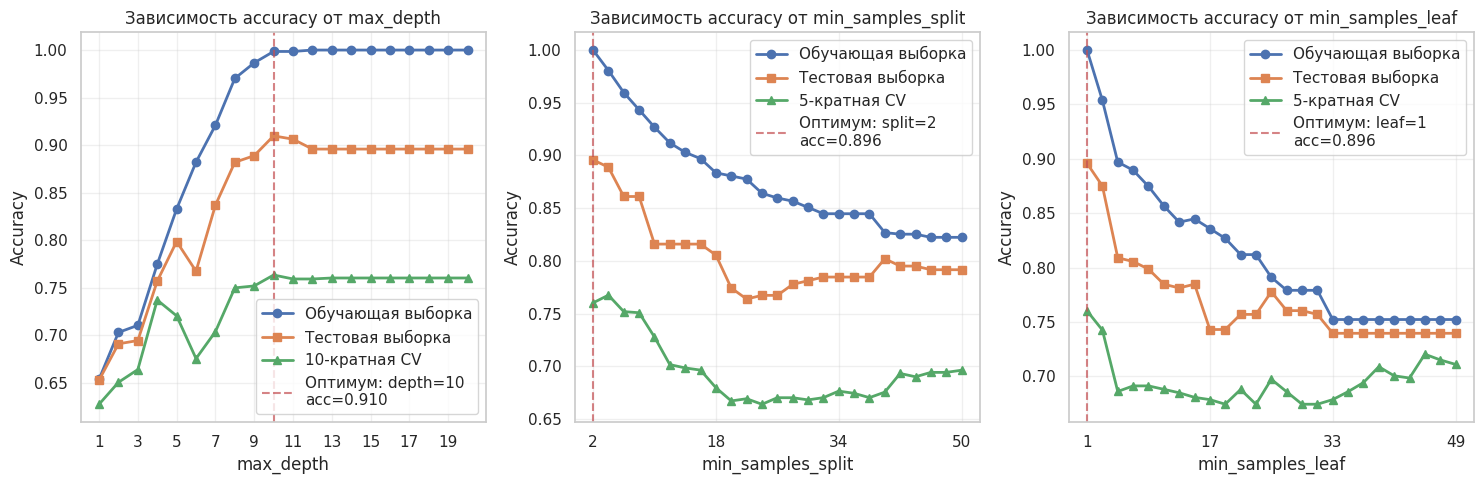

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

def analyze_dataset_parameters(dataset_name, test_size=0.3, random_state=15, cv_folds=10):
    """ Анализ влияния параметров на заданном датасете """
    # загрузка данных
    X, y = load_and_prepare_dataset(dataset_name)

    if X is None or y is None:
        print(f"Не удалось загрузить датасет {dataset_name}")
        return None, None, None, None

    y = LabelEncoder().fit_transform(y)

    # фиксированное разбиение на train/test (70%/30%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    # влияние max_depth
    max_depths = range(1, 21)
    train_scores_depth = []
    test_scores_depth = []
    cv_scores_depth = []

    for depth in max_depths:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
        clf.fit(X_train, y_train)
        train_scores_depth.append(clf.score(X_train, y_train))
        test_scores_depth.append(clf.score(X_test, y_test))
        cv_scores = cross_val_score(clf, X, y, cv=cv_folds)
        cv_scores_depth.append(np.mean(cv_scores))

    # влияние min_samples_split
    min_samples_splits = range(2, 51, 2)
    train_scores_split = []
    test_scores_split = []
    cv_scores_split = []

    for min_split in min_samples_splits:
        clf = DecisionTreeClassifier(min_samples_split=min_split, random_state=random_state)
        clf.fit(X_train, y_train)
        train_scores_split.append(clf.score(X_train, y_train))
        test_scores_split.append(clf.score(X_test, y_test))
        cv_scores = cross_val_score(clf, X, y, cv=cv_folds)
        cv_scores_split.append(np.mean(cv_scores))

    # влияние min_samples_leaf
    min_samples_leaves = range(1, 51, 2)
    train_scores_leaf = []
    test_scores_leaf = []
    cv_scores_leaf = []

    for min_leaf in min_samples_leaves:
        clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=random_state)
        clf.fit(X_train, y_train)
        train_scores_leaf.append(clf.score(X_train, y_train))
        test_scores_leaf.append(clf.score(X_test, y_test))
        cv_scores = cross_val_score(clf, X, y, cv=cv_folds)
        cv_scores_leaf.append(np.mean(cv_scores))

    # результаты
    depth_df = pd.DataFrame({
        'max_depth': list(max_depths),
        'train_accuracy': train_scores_depth,
        'test_accuracy': test_scores_depth,
        'cv_accuracy': cv_scores_depth})

    split_df = pd.DataFrame({
        'min_samples_split': list(min_samples_splits),
        'train_accuracy': train_scores_split,
        'test_accuracy': test_scores_split,
        'cv_accuracy': cv_scores_split})

    leaf_df = pd.DataFrame({
        'min_samples_leaf': list(min_samples_leaves),
        'train_accuracy': train_scores_leaf,
        'test_accuracy': test_scores_leaf,
        'cv_accuracy': cv_scores_leaf})

    # оптимальные значения
    optimal_depth_idx = np.argmax(test_scores_depth)
    optimal_depth = max_depths[optimal_depth_idx]
    optimal_score_depth = test_scores_depth[optimal_depth_idx]

    optimal_split_idx = np.argmax(test_scores_split)
    optimal_split = min_samples_splits[optimal_split_idx]
    optimal_score_split = test_scores_split[optimal_split_idx]

    optimal_leaf_idx = np.argmax(test_scores_leaf)
    optimal_leaf = min_samples_leaves[optimal_leaf_idx]
    optimal_score_leaf = test_scores_leaf[optimal_leaf_idx]

    summary_df = pd.DataFrame({
        'Параметр': ['max_depth', 'min_samples_split', 'min_samples_leaf'],
        'Оптимальное_значение': [optimal_depth, optimal_split, optimal_leaf],
        'Accuracy_на_тесте': [optimal_score_depth, optimal_score_split, optimal_score_leaf],
        'Accuracy_на_обучении': [
            train_scores_depth[optimal_depth_idx],
            train_scores_split[optimal_split_idx],
            train_scores_leaf[optimal_leaf_idx]],
        'Accuracy_CV': [
            cv_scores_depth[optimal_depth_idx],
            cv_scores_split[optimal_split_idx],
            cv_scores_leaf[optimal_leaf_idx]] })

    return depth_df, split_df, leaf_df, summary_df


# анализ tic-tac-toe
depth_df, split_df, leaf_df, summary_df = analyze_dataset_parameters(
    dataset_name='tic-tac-toe',
    test_size=0.3,
    random_state=15,
    cv_folds=10)

# данные из DataFrame для построения графиков
max_depths = depth_df['max_depth'].tolist()
train_scores_depth = depth_df['train_accuracy'].tolist()
test_scores_depth = depth_df['test_accuracy'].tolist()
cv_scores_depth = depth_df['cv_accuracy'].tolist()

min_samples_splits = split_df['min_samples_split'].tolist()
train_scores_split = split_df['train_accuracy'].tolist()
test_scores_split = split_df['test_accuracy'].tolist()
cv_scores_split = split_df['cv_accuracy'].tolist()

min_samples_leaves = leaf_df['min_samples_leaf'].tolist()
train_scores_leaf = leaf_df['train_accuracy'].tolist()
test_scores_leaf = leaf_df['test_accuracy'].tolist()
cv_scores_leaf = leaf_df['cv_accuracy'].tolist()

# оптимальные значения из summary_df
optimal_depth = summary_df.loc[summary_df['Параметр'] == 'max_depth', 'Оптимальное_значение'].values[0]
optimal_score = summary_df.loc[summary_df['Параметр'] == 'max_depth', 'Accuracy_на_тесте'].values[0]
optimal_split = summary_df.loc[summary_df['Параметр'] == 'min_samples_split', 'Оптимальное_значение'].values[0]
optimal_score_split = summary_df.loc[summary_df['Параметр'] == 'min_samples_split', 'Accuracy_на_тесте'].values[0]
optimal_leaf = summary_df.loc[summary_df['Параметр'] == 'min_samples_leaf', 'Оптимальное_значение'].values[0]
optimal_score_leaf = summary_df.loc[summary_df['Параметр'] == 'min_samples_leaf', 'Accuracy_на_тесте'].values[0]

# индексы оптимальных значений
optimal_depth_idx = list(max_depths).index(optimal_depth)
optimal_split_idx = list(min_samples_splits).index(optimal_split)
optimal_leaf_idx = list(min_samples_leaves).index(optimal_leaf)


# графики
plt.figure(figsize=(15, 5))

# График 1: max_depth
plt.subplot(1, 3, 1)
plt.plot(max_depths, train_scores_depth, 'o-', label='Обучающая выборка', linewidth=2)
plt.plot(max_depths, test_scores_depth, 's-', label='Тестовая выборка', linewidth=2)
plt.plot(max_depths, cv_scores_depth, '^-', label='10-кратная CV', linewidth=2)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от max_depth')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(max_depths[::2])

plt.axvline(x=optimal_depth, color='r', linestyle='--', alpha=0.7,
            label=f'Оптимум: depth={optimal_depth}\nacc={optimal_score:.3f}')
plt.legend()

# График 2: min_samples_split
plt.subplot(1, 3, 2)
plt.plot(min_samples_splits, train_scores_split, 'o-', label='Обучающая выборка', linewidth=2)
plt.plot(min_samples_splits, test_scores_split, 's-', label='Тестовая выборка', linewidth=2)
plt.plot(min_samples_splits, cv_scores_split, '^-', label='10-кратная CV', linewidth=2)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от min_samples_split')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(min_samples_splits[::8])

plt.axvline(x=optimal_split, color='r', linestyle='--', alpha=0.7,
            label=f'Оптимум: split={optimal_split}\nacc={optimal_score_split:.3f}')
plt.legend()

# График 3: min_samples_leaf
plt.subplot(1, 3, 3)
plt.plot(min_samples_leaves, train_scores_leaf, 'o-', label='Обучающая выборка', linewidth=2)
plt.plot(min_samples_leaves, test_scores_leaf, 's-', label='Тестовая выборка', linewidth=2)
plt.plot(min_samples_leaves, cv_scores_leaf, '^-', label='10-кратная CV', linewidth=2)
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от min_samples_leaf')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(min_samples_leaves[::8])

plt.axvline(x=optimal_leaf, color='r', linestyle='--', alpha=0.7,
            label=f'Оптимум: leaf={optimal_leaf}\nacc={optimal_score_leaf:.3f}')
plt.legend()

plt.tight_layout()
plt.show()


# # сохранение результатов в .csv (по желанию)
# depth_df.to_csv('datasets/tic_tac_toe_max_depth_analysis.csv', index=False)
# print(f"Данные сохранены: tic_tac_toe_max_depth_analysis.csv")

# split_df.to_csv('datasets/tic_tac_toe_min_samples_split_analysis.csv', index=False)
# print(f"Данные сохранены: tic_tac_toe_min_samples_split_analysis.csv")

# leaf_df.to_csv('datasets/tic_tac_toe_min_samples_leaf_analysis.csv', index=False)
# print(f"Данные сохранены: tic_tac_toe_min_samples_leaf_analysis.csv")

# summary_df.to_csv('datasets/tic_tac_toe_optimal_params_summary.csv', index=False)
# print(f"Данные сохранены: tic_tac_toe_optimal_params_summary.csv (сводная таблица)")

__2.4. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

**Категориальные датасеты** (mushrooms, tic-tac-toe, cars, nursery):
  - OneHot лучше для номинальных признаков (без естественного порядка; создает разреженность при многих категориях)
  - Ordinal лучше для порядковых признаков (создает ложный порядок для номинальных признаков)

**Числовой датасет** (user-knowledge-modeling):
  - Все методы дают одинаковые результаты (OneHot не применяется)

**Компонента случайности:** разделение данных, кросс-валидация, random_state, порядок кодирования

**Улучшение:**
- OneHot: регуляризация деревьев, случайные леса
- Ordinal: правильный порядок кодирования, гибридный подход

Нет универсального лучшего метода. Выбор метода зависит от природы признаков. Качество можно улучшить правильным выбором кодирования, регуляризацией и ансамблевыми методами.

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`)

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [3]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# 1. Загрузка данных
df = pd.read_csv('datasets/HomeCredit/application_train.csv')
print(f"Размер данных: {df.shape}")

# 2. Выделение целевой переменной
Y = df['TARGET']
print(f"\nЦелевая переменная распределение:\n{Y.value_counts(normalize=True).to_string(name=False)}")


# 3. Удаление ненужных столбцов

    # SK_ID_CURR - ID клиента
df = df.drop('SK_ID_CURR', axis=1)

    # столбцы с более чем 50% пропусков
missing_percent = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_percent[missing_percent > 50].index.tolist()
df = df.drop(columns=columns_to_drop)
print("-"*48)
print(f"Удалено {len(columns_to_drop)} столбцов с >50% пропусков")

    # столбцы, содержащие только одно уникальное значение
for col in df.columns:
    if df[col].nunique() == 1:
        df = df.drop(col, axis=1)
        print(f"Удален столбец {col} с одним уникальным значением")

    # целевая переменная
X = df.drop('TARGET', axis=1)
print(f"Осталось признаков: {X.shape[1]}")
print("-"*48)

# 4. Обработка пропусков и определение типов данных

    # разделение признаков на числовые и категориальные
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

    # заполнение пропусков медианой(для числовых) и модой (для категориальных)
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
for col in categorical_cols:
    mode_val = X[col].mode()
    if not mode_val.empty:
        X[col] = X[col].fillna(mode_val[0])
    else:
        X[col] = X[col].fillna('Unknown')

print(f"Пропуски после заполнения: {X.isnull().sum().sum()}")
print("-"*48)

    # преобразуем категориальные признаки в тип 'category'
for col in categorical_cols:
    X[col] = X[col].astype('category')


# 5. Фиксированное разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=0,
    stratify=Y)

print("-"*48)
print(f"Размер train: {X_train.shape}")
print(f"Размер test: {X_test.shape}")
print(f"Баланс классов в train: {np.bincount(y_train) / len(y_train)}")
print(f"Баланс классов в test: {np.bincount(y_test) / len(y_test)}")

# Сохранение индексов категориальных признаков и обработанных данных
cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]
print("-"*48)
print(f"Индексы категориальных признаков:\n {cat_features_indices}")

joblib.dump((X_train, X_test, y_train, y_test, cat_features_indices),
            'datasets/HomeCredit/processed_data.pkl')
print("-"*48)
print("\nДанные сохранены в 'datasets/HomeCredit/processed_data.pkl'")

Размер данных: (256293, 122)

Целевая переменная распределение:
TARGET
0    0.918964
1    0.081036
------------------------------------------------
Удалено 41 столбцов с >50% пропусков
Осталось признаков: 79
------------------------------------------------
Числовых признаков: 66
Категориальных признаков: 13
Пропуски после заполнения: 0
------------------------------------------------
------------------------------------------------
Размер train: (179405, 79)
Размер test: (76888, 79)
Баланс классов в train: [0.91896547 0.08103453]
Баланс классов в test: [0.91896005 0.08103995]
------------------------------------------------
Индексы категориальных признаков:
 [0, 1, 2, 3, 9, 10, 11, 12, 13, 25, 29, 37, 47]
------------------------------------------------

Данные сохранены в 'datasets/HomeCredit/processed_data.pkl'


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [4]:
!pip install -q lightgbm
import lightgbm as lgb

!pip install -q catboost
import catboost as cb

from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
import time


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [5]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# выделение вещественных признаков (исключение категориальных)
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
print(f"Числовых признаков: {len(numeric_cols)}")

X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# оценка PR-AUC
def evaluate_pr_auc(model, X_test, y_test):
    # Для LightGBM (обученного через lgb.train)
    if isinstance(model, lgb.Booster):
        y_pred_proba = model.predict(X_test)
    # Для CatBoostClassifier
    elif hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Для CatBoost с prediction_type
        y_pred_proba = model.predict(X_test, prediction_type='Probability')[:, 1]
    return average_precision_score(y_test, y_pred_proba)


# 1. LightGBM
print("\n" + "="*35)
print("Обучение LightGBM:")
print("-"*35)

start_time = time.time()

# датасет LightGBM
train_data_lgb = lgb.Dataset(X_train_numeric, label=y_train)

# обучение модели
lgb_model = lgb.train(
    params={'objective': 'binary', 'verbose': -1, 'random_state': 15},
    train_set=train_data_lgb,
    num_boost_round=100)

lgb_time = time.time() - start_time

# оценка LightGBM
lgb_pr_auc = evaluate_pr_auc(lgb_model, X_test_numeric, y_test)

print(f"Время обучения LightGBM: {lgb_time:.2f} сек")
print(f"PR-AUC LightGBM: {lgb_pr_auc:.4f}")


# 2. CatBoost
print("\n" + "="*35)
print("Обучение CatBoost:")
print("-"*35)

start_time = time.time()

# инициализация CatBoost
cb_model = cb.CatBoostClassifier(
    iterations=100, # дефолт = 1000, 100 - для скорости сравнения
    verbose=False,
    random_state=15)

# обучение модели
cb_model.fit(X_train_numeric, y_train)

cb_time = time.time() - start_time

# оценка
cb_pr_auc = evaluate_pr_auc(cb_model, X_test_numeric, y_test)

print(f"Время обучения CatBoost: {cb_time:.2f} сек")
print(f"PR-AUC CatBoost: {cb_pr_auc:.4f}")

# сохранение моделей (опционально)
joblib.dump(lgb_model, 'lgb_default_model.pkl');
joblib.dump(cb_model, 'cb_default_model.pkl');

Числовых признаков: 66

Обучение LightGBM:
-----------------------------------
Время обучения LightGBM: 18.65 сек
PR-AUC LightGBM: 0.2262

Обучение CatBoost:
-----------------------------------
Время обучения CatBoost: 15.44 сек
PR-AUC CatBoost: 0.2125


In [ ]:
# 3. Анализ разницы в качестве
print(f"\nРазница в PR-AUC: {abs(lgb_pr_auc - cb_pr_auc):.4f}\n")

# сравнительные таблицы
print("="*90)
print(f"{'Параметр':<40} {'LightGBM':<25} {'CatBoost':<20}")
print("-"*90)

print(f"{'1. Обработка пропущенных значений':<40} {'Автоматическая':<25} {'Требует указания':<20}")
print(f"{'2. Алгоритм построения деревьев':<40} {'Leaf-wise рост':<25} {'Symmetric trees':<20}")
print(f"{'   - Характеристика':<40} {'Более глубокие':<25} {'Более сбалансированные':<20}")
print(f"{'3. Борьба с переобучением':<40} {'':<20} {'':<20}")
print(f"{'   - Основной параметр':<40} {'min_data_in_leaf=20':<25} {'l2_leaf_reg=3':<20}")
print(f"{'   - Доп. параметры':<40} {'feature_fraction=0.8':<25} {'depth=6':<20}")
print(f"{'4. Вычисление градиента':<40} {'GOSS':<25} {'Ordered Boosting':<20}")
print(f"{'   - Особенность':<40} {'Выборка по градиенту':<25} {'Защита от смещения':<20}")
print("="*90 + "\n")

print("="*60)
print(f"{'Метрика':<20} {'LightGBM':<15} {'CatBoost':<15} {'Разница':<10}")
print("-"*60)
print(f"{'Время (сек)':<20} {lgb_time:<15.2f} {cb_time:<15.2f} {abs(lgb_time - cb_time):<10.2f}")
print(f"{'PR-AUC':<20} {lgb_pr_auc:<15.4f} {cb_pr_auc:<15.4f} {abs(lgb_pr_auc - cb_pr_auc):<10.4f}")
print("="*60)

print("\nРазница в качестве небольшая - на вещественных признаках оба алгоритма работают схоже")


Разница в PR-AUC: 0.0115

Параметр                                 LightGBM                  CatBoost            
------------------------------------------------------------------------------------------
1. Обработка пропущенных значений        Автоматическая            Требует указания    
2. Алгоритм построения деревьев          Leaf-wise рост            Symmetric trees     
   - Характеристика                      Более глубокие            Более сбалансированные
3. Борьба с переобучением                                                         
   - Основной параметр                   min_data_in_leaf=20       l2_leaf_reg=3       
   - Доп. параметры                      feature_fraction=0.8      depth=6             
4. Вычисление градиента                  GOSS                      Ordered Boosting    
   - Особенность                         Выборка по градиенту      Защита от смещения  

Метрика              LightGBM        CatBoost        Разница   
----------------------------

__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# 1. параметры для LightGBM
print("_"*60 + "\n")
print("Подбор параметров для LightGBM:")
print("_"*60)

  # создание модели LightGBM для GridSearchCV
lgb_grid_model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    verbose=-1,
    random_state=15,
    n_jobs=-1)

  # параметры для GridSearch (больше вариантов не тянет)
lgb_param_grid = {
    'n_estimators': [100, 200],           # Количество деревьев
    'max_depth': [5, 7],                  # Глубина деревьев
    'learning_rate': [0.05, 0.1],         # Темп обучения
    'min_child_samples': [20, 30] }       # Минимум объектов


  # настройка GridSearchCV
start_time = time.time()

lgb_grid_search = GridSearchCV(
    estimator=lgb_grid_model,
    param_grid=lgb_param_grid,
    cv=3,
    scoring='average_precision',  # PR-AUC
    verbose=2,
    n_jobs=-1)

  # обучение с подбором параметров
lgb_grid_search.fit(X_train_numeric, y_train)

lgb_search_time = time.time() - start_time

  # оценка на тестовой выборке
lgb_best_model = lgb_grid_search.best_estimator_
lgb_best_pr_auc = evaluate_pr_auc(lgb_best_model, X_test_numeric, y_test)

  # результаты LightGBM
print("\nGridSearchCV LightGBM:")
print(f"  - время обучения {lgb_search_time:.2f} сек")
print(f"  - лучшие параметры:")
for param, value in lgb_grid_search.best_params_.items():
    print(f"      {param}: {value}")
print(f"\nPR-AUC на тесте: {lgb_best_pr_auc:.4f}")



# 2. параметры для CatBoost
print("_"*60 + "\n")
print("Подбор параметров для CatBoost:")
print("_"*60)

  # создание модели CatBoost для GridSearchCV
cb_grid_model = cb.CatBoostClassifier(
    verbose=False,
    random_state=15,
    thread_count=-1)

  # параметры для GridSearch (больше вариантов не тянет ноутбук)
cb_param_grid = {
    'iterations': [200, 300],            # Количество деревьев
    'depth': [5, 7],                     # Глубина деревьев
    'learning_rate': [0.05, 0.1],        # Темп обучения
    'l2_leaf_reg': [3, 5] }              # Регуляризация

  # настройка GridSearchCV
start_time = time.time()

cb_grid_search = GridSearchCV(
    estimator=cb_grid_model,
    param_grid=cb_param_grid,
    cv=3,
    scoring='average_precision',  # PR-AUC
    verbose=2,
    n_jobs=-1)

  # обучение с подбором параметров
cb_grid_search.fit(X_train_numeric, y_train)

cb_search_time = time.time() - start_time

  # оценка на тестовой выборке
cb_best_model = cb_grid_search.best_estimator_
cb_best_pr_auc = evaluate_pr_auc(cb_best_model, X_test_numeric, y_test)

  # результаты CatBoost
print("\nGridSearchCV CatBoost:")
print(f"  - время обучения {cb_search_time:.2f} сек")
print(f"  - лучшие параметры:")
for param, value in cb_grid_search.best_params_.items():
    print(f"      {param}: {value}")
print(f"\nPR-AUC на тесте: {cb_best_pr_auc:.4f}")



# сохранение лучших моделей
joblib.dump(lgb_best_model, 'lgb_best_model.pkl');
joblib.dump(cb_best_model, 'cb_best_model.pkl');

____________________________________________________________

Подбор параметров для LightGBM:
____________________________________________________________
Fitting 3 folds for each of 16 candidates, totalling 48 fits

GridSearchCV LightGBM:
  - время обучения 611.76 сек
  - лучшие параметры:
      learning_rate: 0.1
      max_depth: 5
      min_child_samples: 30
      n_estimators: 200

PR-AUC на тесте: 0.2283
____________________________________________________________

Подбор параметров для CatBoost:
____________________________________________________________
Fitting 3 folds for each of 16 candidates, totalling 48 fits

GridSearchCV CatBoost:
  - время обучения 682.57 сек
  - лучшие параметры:
      depth: 7
      iterations: 300
      l2_leaf_reg: 5
      learning_rate: 0.05

PR-AUC на тесте: 0.2299


In [ ]:
# 3. анализ соотношения глубины и количества деревьев в зависимости от алгоритма

# DataFrame для анализа результатов
results_data = {
    'Алгоритм': ['LightGBM', 'CatBoost'],
    'Оптимальная глубина': [
        lgb_grid_search.best_params_['max_depth'],
        cb_grid_search.best_params_['depth'] ],

    'Оптимальное кол-во деревьев': [
        lgb_grid_search.best_params_['n_estimators'],
        cb_grid_search.best_params_['iterations'] ],

    'Оптимальный темп обучения': [
        lgb_grid_search.best_params_['learning_rate'],
        cb_grid_search.best_params_['learning_rate'] ],

    'Доп. параметр': [
        lgb_grid_search.best_params_['min_child_samples'],
        cb_grid_search.best_params_['l2_leaf_reg'] ],

    'Время подбора (сек)': [lgb_search_time, cb_search_time],
    'PR-AUC на тесте': [lgb_best_pr_auc, cb_best_pr_auc] }

print("\nОптимальные параметры:")
print(pd.DataFrame(results_data).to_string(index=False))


# соотношения
print("\nСсоотношение глубины и количества деревьев:")


lgb_depth = lgb_grid_search.best_params_['max_depth']
lgb_trees = lgb_grid_search.best_params_['n_estimators']

if lgb_depth == -1:
    print(f"  → LightGBM выбрал максимальную глубину ({lgb_depth}) - так нужно меньше деревьев ({lgb_trees})")
elif lgb_depth <= 5:
    print(f"  → LightGBM выбрал небольшую глубину ({lgb_depth}) - так обычно нужно больше деревьев ({lgb_trees})")
else:
    print(f"  → LightGBM выбрал среднюю глубину ({lgb_depth}) и среднее количество деревьев ({lgb_trees})")


cb_depth = cb_grid_search.best_params_['depth']
cb_trees = cb_grid_search.best_params_['iterations']

if cb_depth <= 5:
    print(f"  → CatBoost выбрал небольшую глубину ({cb_depth}) - связано с использованием симметричных деревьев ({cb_trees})")
else:
    print(f"  → CatBoost выбрал глубину {cb_depth} и количество деревьев ({cb_trees})")

print(f"\nОбщее время: {lgb_search_time + cb_search_time:.2f} сек")


Оптимальные параметры:
Алгоритм  Оптимальная глубина  Оптимальное кол-во деревьев  Оптимальный темп обучения  Доп. параметр  Время подбора (сек)  PR-AUC на тесте
LightGBM                    7                          200                       0.05             30           700.029023         0.226290
CatBoost                    5                          300                       0.10              3           801.197824         0.225878

Ссоотношение глубины и количества деревьев:
  → LightGBM выбрал среднюю глубину (7) и среднее количество деревьев (200)
  → CatBoost выбрал небольшую глубину (5) - связано с использованием симметричных деревьев (300)

Общее время: 1501.23 сек


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# подготовка данных:
categorical_cols = X_train.select_dtypes(include=['category']).columns
X_train_cat = X_train[categorical_cols]
X_test_cat = X_test[categorical_cols]
print(f"- Категориальных признаков: {len(categorical_cols)}")
print(f"- Числовых признаков: {X_train_numeric.shape[1]}")


# способ №1 ONE-HOT ENCODING
print("_"*40 + "\n")
print("\nOne-Hot Encoding")
print("_"*40)

start_time = time.time()

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe_encoder.fit_transform(X_train_cat)
X_test_ohe = ohe_encoder.transform(X_test_cat)

X_train_ohe_full = np.hstack([X_train_numeric.values, X_train_ohe])
X_test_ohe_full = np.hstack([X_test_numeric.values, X_test_ohe])

ohe_time = time.time() - start_time
print(f"   - Время (сек): {ohe_time:.2f}")
print(f"   - Размерность (признаков): {X_train_ohe_full.shape[1]}")


# способ №2 счетчики со сглаживангием
print("_"*40 + "\n")
print("\nСчетчики со сглаживанием")
print("_"*40)

start_time = time.time()

smoothing = 100
global_mean = y_train.mean()


def calculate_smooth_encoding(X_train_cat, X_test_cat, y_train, smoothing, global_mean):
    ''' расчет счетчиков '''

    # преобразование категориальных колонок в строки
    X_train_cat_str = X_train_cat.astype(str)
    X_test_cat_str = X_test_cat.astype(str)

    # melt для преобразования колонок в строку-значение пары
    train_melted = X_train_cat_str.reset_index().melt(
        id_vars='index',
        value_vars=X_train_cat_str.columns,
        var_name='feature',
        value_name='value')

    # целевую переменную
    train_melted['target'] = train_melted['index'].map(y_train)

    # группировка по feature и value
    stats = train_melted.groupby(['feature', 'value']).agg(
        mean=('target', 'mean'),
        count=('target', 'count')).reset_index()

    # сглаживание
    stats['smooth'] = (stats['count'] * stats['mean'] + smoothing * global_mean) / (stats['count'] + smoothing)

    # мультииндекс для быстрого доступа
    stats_multiindex = stats.set_index(['feature', 'value'])['smooth']

    # мультииндекс для train данных
    train_indices = pd.MultiIndex.from_arrays([
        X_train_cat_str.columns.repeat(len(X_train_cat_str)),
        X_train_cat_str.values.ravel(order='F')
    ], names=['feature', 'value'])

    # маппинг значений
    train_mapped = stats_multiindex.reindex(train_indices).values

    # восстанавление оригинальной формы
    X_train_smooth = pd.DataFrame(
        train_mapped.reshape(X_train_cat_str.shape, order='F'),
        index=X_train_cat_str.index,
        columns=X_train_cat_str.columns)

    # мультииндекс для test данных
    test_indices = pd.MultiIndex.from_arrays([
        X_test_cat_str.columns.repeat(len(X_test_cat_str)),
        X_test_cat_str.values.ravel(order='F')
    ], names=['feature', 'value'])

    # маппинг значений (неизвестные -> global_mean)
    test_mapped = stats_multiindex.reindex(test_indices).fillna(global_mean).values

    # восстанавление оригинальной формы
    X_test_smooth = pd.DataFrame(
        test_mapped.reshape(X_test_cat_str.shape, order='F'),
        index=X_test_cat_str.index,
        columns=X_test_cat_str.columns)

    return X_train_smooth, X_test_smooth

X_train_smooth, X_test_smooth = calculate_smooth_encoding(
    X_train_cat, X_test_cat, y_train, smoothing, global_mean)


# объединение с вещественными признаками
X_train_smooth_full = pd.concat([
    pd.DataFrame(X_train_numeric, index=X_train.index),
    X_train_smooth], axis=1)

X_test_smooth_full = pd.concat([
    pd.DataFrame(X_test_numeric, index=X_test.index),
    X_test_smooth], axis=1)

smooth_time = time.time() - start_time
print(f"   - Время (сек): {smooth_time:.2f}")
print(f"   - Размерность (признаков): {X_train_smooth_full.shape[1]}")
print("_"*40)

- Категориальных признаков: 13
- Числовых признаков: 66
________________________________________


One-Hot Encoding
________________________________________
   - Время (сек): 2.12
   - Размерность (признаков): 192
________________________________________


Счетчики со сглаживанием
________________________________________
   - Время (сек): 5.01
   - Размерность (признаков): 79
________________________________________


In [ ]:
def optimize_model(model_class, X_train_data, X_test_data, param_grid,
                   model_name, is_catboost=False, cat_features=None, **fit_params):
    ''' функция оптимизации с GridSearchCV '''
    print(f"\n{model_name}:")
    print("_" * 20)

    start_time = time.time()

    # модель
    if is_catboost:
        model = cb.CatBoostClassifier(
            verbose=False,
            random_state=15,
            thread_count=-1,
            **{k: v for k, v in fit_params.items() if k != 'cat_features'})
    else:
        # Для LightGBM преобразуем категориальные признаки
        if cat_features is not None and isinstance(X_train_data, pd.DataFrame):
            # Копируем данные и преобразуем категориальные колонки в category
            X_train_data_processed = X_train_data.copy()
            X_test_data_processed = X_test_data.copy()

            for col_idx in cat_features:
                if col_idx < len(X_train_data.columns):
                    col_name = X_train_data.columns[col_idx]
                    X_train_data_processed[col_name] = X_train_data_processed[col_name].astype('category')
                    X_test_data_processed[col_name] = X_test_data_processed[col_name].astype('category')

            cat_features_list = cat_features
        else:
            X_train_data_processed = X_train_data
            X_test_data_processed = X_test_data
            cat_features_list = None

        model = lgb.LGBMClassifier(
            objective='binary',
            verbose=-1,
            random_state=15,
            n_jobs=-1)

    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='average_precision',
        verbose=0,
        n_jobs=-1)

    # обучение
    if is_catboost and cat_features is not None:
        grid_search.fit(X_train_data, y_train, cat_features=cat_features)
    elif not is_catboost and cat_features_list is not None:
        # Для LightGBM указываем категориальные признаки
        grid_search.fit(X_train_data_processed, y_train,
                         categorical_feature=cat_features_list)
    else:
        grid_search.fit(X_train_data, y_train)

    search_time = time.time() - start_time

    # оценка
    best_model = grid_search.best_estimator_

    # Подготовка тестовых данных для предсказания
    if is_catboost and cat_features is not None:
        y_pred_proba = best_model.predict_proba(X_test_data)[:, 1]
    elif not is_catboost and cat_features_list is not None:
        y_pred_proba = best_model.predict_proba(X_test_data_processed)[:, 1]
    else:
        y_pred_proba = best_model.predict_proba(X_test_data)[:, 1]

    pr_auc = average_precision_score(y_test, y_pred_proba)

    print(f"  Время: {search_time:.2f} сек")
    print(f"  PR-AUC: {pr_auc:.4f}")

    return search_time, pr_auc, best_model, grid_search.best_params_, X_test_data


# параметры для оптимизации (уменьшены для скорости)
lgb_params = {
    'n_estimators': [100, 200],           # 2 значения
    'max_depth': [5, 7],                  # 2 значения
    'learning_rate': [0.05, 0.1]          # 2 значения
}

cb_params = {
    'iterations': [100, 200],             # 2 значения
    'depth': [5, 7],                      # 2 значения
    'learning_rate': [0.05, 0.1]          # 2 значения
}

# оптимизация на разных датасетах
print("\nОптимизация моделей на разных датасетах (GridSearchCV):")
print("="*62)

# датасет для встроенных методов
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Преобразуем только те колонки, которые существуют в обоих датасетах
common_cat_cols = [col for col in categorical_cols if col in X_train_original.columns and col in X_test_original.columns]

for col in common_cat_cols:
    X_train_original[col] = X_train_original[col].astype(str)
    X_test_original[col] = X_test_original[col].astype(str)

print(f"Преобразовано {len(common_cat_cols)} категориальных признаков из {len(categorical_cols)}")

# Индексы категориальных признаков для LightGBM (только те, что есть в X_train_original)
cat_features_indices_for_lgb = [i for i, col in enumerate(X_train_original.columns)
                               if col in common_cat_cols]

# список экспериментов
experiments = [
    # (название, данные train, данные test, параметры, is_catboost, дополнительные параметры)
    ("LightGBM + OHE", X_train_ohe_full, X_test_ohe_full, lgb_params, False, {}),
    ("CatBoost + OHE", X_train_ohe_full, X_test_ohe_full, cb_params, True, {}),
    ("LightGBM + Smooth", X_train_smooth_full, X_test_smooth_full, lgb_params, False, {}),
    ("CatBoost + Smooth", X_train_smooth_full, X_test_smooth_full, cb_params, True, {}),
    ("LightGBM встроенный", X_train_original, X_test_original, lgb_params, False,
     {'cat_features': cat_features_indices_for_lgb}),
    ("CatBoost встроенный", X_train_original, X_test_original, cb_params, True,
     {'cat_features': common_cat_cols})]

# запуск экспериментов
results = []
best_models = {}  # Для хранения лучших моделей по типу
all_models = []   # Для хранения всех моделей для блендинга

for exp_name, X_tr, X_te, params, is_cb, extra_params in experiments:
    time_taken, pr_auc, model, best_params, X_test_for_model = optimize_model(
        cb.CatBoostClassifier if is_cb else lgb.LGBMClassifier,
        X_tr, X_te, params, exp_name, is_cb, **extra_params)

    # Сохраняем модель в словарь по типу
    if is_cb:
        if 'CatBoost' not in best_models or pr_auc > best_models['CatBoost']['pr_auc']:
            best_models['CatBoost'] = {
                'model': model,
                'pr_auc': pr_auc,
                'name': exp_name,
                'params': best_params,
                'X_test_data': X_test_for_model
            }
    else:
        if 'LightGBM' not in best_models or pr_auc > best_models['LightGBM']['pr_auc']:
            best_models['LightGBM'] = {
                'model': model,
                'pr_auc': pr_auc,
                'name': exp_name,
                'params': best_params,
                'X_test_data': X_test_for_model
            }

    # Сохраняем все модели для блендинга
    all_models.append({
        'Метод': exp_name,
        'Модель': model,
        'PR-AUC': pr_auc,
        'Время (сек)': time_taken,
        'Размерность': X_tr.shape[1],
        'X_test_data': X_test_for_model,
        'Тип': 'CatBoost' if is_cb else 'LightGBM'
    })

    results.append({
        'Метод': exp_name,
        'Время (сек)': time_taken,
        'PR-AUC': pr_auc,
        'Размерность': X_tr.shape[1]})

# Сохраняем лучшие модели в глобальные переменные
lgb_best_model = best_models.get('LightGBM', {}).get('model')
cb_best_model = best_models.get('CatBoost', {}).get('model')

# Сохраняем все модели для блендинга
joblib.dump(all_models, 'all_models_for_blending.pkl')
print("\nВсе модели сохранены в 'all_models_for_blending.pkl'")

# Выводим информацию о лучших моделях
print("\nЛучшие модели:")
print("="*60)

if lgb_best_model:
    lgb_best_info = best_models['LightGBM']
    print(f"\nЛучшая модель LightGBM: {lgb_best_info['name']}")
    print(f"  PR-AUC: {lgb_best_info['pr_auc']:.4f}")
    print("  Параметры:")
    for param, value in lgb_best_info['params'].items():
        print(f"    {param}: {value}")

if cb_best_model:
    cb_best_info = best_models['CatBoost']
    print(f"\nЛучшая модель CatBoost: {cb_best_info['name']}")
    print(f"  PR-AUC: {cb_best_info['pr_auc']:.4f}")
    print("  Параметры:")
    for param, value in cb_best_info['params'].items():
        print(f"    {param}: {value}")

# Сохранение лучших моделей
if lgb_best_model:
    joblib.dump(lgb_best_model, 'lgb_best_categorical.pkl')
    print("\nLightGBM модель сохранена в 'lgb_best_categorical.pkl'")

if cb_best_model:
    joblib.dump(cb_best_model, 'cb_best_categorical.pkl')
    print("CatBoost модель сохранена в 'cb_best_categorical.pkl'")


Оптимизация моделей на разных датасетах (GridSearchCV):
Преобразовано 13 категориальных признаков из 13

LightGBM + OHE:
____________________
  Время: 283.64 сек
  PR-AUC: 0.2363

CatBoost + OHE:
____________________
  Время: 716.37 сек
  PR-AUC: 0.2351

LightGBM + Smooth:
____________________
  Время: 285.74 сек
  PR-AUC: 0.2371

CatBoost + Smooth:
____________________
  Время: 265.36 сек
  PR-AUC: 0.2362

CatBoost встроенный:
____________________
  Время: 1159.05 сек
  PR-AUC: 0.2357

LightGBM встроенный:
____________________
  Время: 311.39 сек
  PR-AUC: 0.2359

Все модели сохранены в 'all_models_for_blending.pkl'

Лучшие модели:

Лучшая модель LightGBM: LightGBM + Smooth
  PR-AUC: 0.2371
  Параметры:
    learning_rate: 0.05
    max_depth: 7
    n_estimators: 200

Лучшая модель CatBoost: CatBoost + Smooth
  PR-AUC: 0.2362
  Параметры:
    depth: 7
    iterations: 200
    learning_rate: 0.1

LightGBM модель сохранена в 'lgb_best_categorical.pkl'
CatBoost модель сохранена в 'cb_best_

__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# загрузка моделей из переменных или файлов
if 'all_models' in locals() and all_models:
    models_data = all_models.copy()
else:
    print("Переменная all_models не найдена")
    try:
        models_data = joblib.load('all_models_for_blending.pkl')
        print(f"Загружено {len(models_data)} моделей из файла")
    except Exception as e:
        print(f"Не удалось загрузить модели: {e}")
        models_data = []

if not models_data:
    print("Модели не найдены")
else:

    # предсказания от всех моделей
    predictions = []
    names = []
    individual_aucs = []

    for m in models_data:
        model = m['Модель']
        model_name = m['Метод']

        # gропуск встроенных моделей
        if 'встроенный' in model_name:
            continue

        try:
            # тестовые данные для модели
            if 'Smooth' in model_name:
                test_data = X_test_smooth_full
            elif 'OHE' in model_name:
                test_data = X_test_ohe_full
            else:
                test_data = X_test_numeric

            # получение предсказаний
            if hasattr(model, 'predict_proba'):
                pred = model.predict_proba(test_data)[:, 1]
            else:
                try:
                    pred = model.predict(test_data, prediction_type='Probability')[:, 1]
                except:
                    pred = model.predict(test_data)

            predictions.append(pred)
            names.append(model_name)

            # PR-AUC для данной модели
            auc = average_precision_score(y_test, pred)
            individual_aucs.append(auc)

        except Exception as e:
            print(f"{model_name}: не найдено ({str(e)[:50]})")

    if len(predictions) >= 2:

        print("\nВзвешенное усреднение (вес по PR-AUC):")
        print("_" * 38)

        # нормализация весов (чем выше PR-AUC, тем больше вес)
        weights = np.array(individual_aucs)
        weights = weights / weights.sum()

        print(f"\n{'Модель':<18} | {'PR-AUC':<7.4} | {'Вес':<8}")
        print("-" * 38)

        for name, auc, weight in zip(names, individual_aucs, weights):
            print(f"{name:<18} | {auc:>7.4f} | {weight:>7.4f}")

        # взвешенное усреднение
        blended = np.zeros_like(predictions[0])
        for pred, weight in zip(predictions, weights):
            blended += pred * weight

        blended_auc = average_precision_score(y_test, blended)


        # сравнение
        best_individual_auc = max(individual_aucs)
        best_individual_name = names[np.argmax(individual_aucs)]

        print("\nСравнение (по PR-AUC):")
        print("_" * 38)
        print(f"Блендинг: {blended_auc:.4f}")
        print(f"{best_individual_name}: {best_individual_auc:.4f} (лучшая модель)")

        if blended_auc > best_individual_auc:
            improvement = blended_auc - best_individual_auc
            print(f"  - Блендинг улучшил качество на +{improvement:.4f}")
        else:
            print(f"  - Блендинг не улучшил качество")

        # статистика по весам и выыводы
        print("\nАнализ:")
        print("_"*45)

        max_weight = max(weights)
        min_weight = min(weights)

        print(f"Максимальный вес: {max_weight:.3f} ({names[np.argmax(weights)]})")
        print(f"Минимальный вес: {min_weight:.3f} ({names[np.argmin(weights)]})")
        print("_" * 45)

        if blended_auc > best_individual_auc:
            print(f"Блендинг эффективен. \nРазнообразие моделей компенсирует индивидуальные ошибки.")
        else:
            print(f"Блендинг неэффективен. \nМодели делают схожие ошибки или слабые модели перевешивают.")

    else:
        print("Недостаточно предсказаний для блендинга")


Взвешенное усреднение (вес по PR-AUC):
______________________________________

Модель             | PR-A    | Вес     
--------------------------------------
LightGBM + OHE     |  0.2363 |  0.2501
CatBoost + OHE     |  0.2351 |  0.2489
LightGBM + Smooth  |  0.2371 |  0.2510
CatBoost + Smooth  |  0.2362 |  0.2500

Сравнение (по PR-AUC):
______________________________________
Блендинг: 0.2392
LightGBM + Smooth: 0.2371 (лучшая модель)
  - Блендинг улучшил качество на +0.0021

Анализ:
_____________________________________________
Максимальный вес: 0.251 (LightGBM + Smooth)
Минимальный вес: 0.249 (CatBoost + OHE)
_____________________________________________
Блендинг эффективен. 
Разнообразие моделей компенсирует индивидуальные ошибки.


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

Данные скопированы: train (179405, 66), test (76888, 66)
Модели успешно загружены из файлов задания 3.3

LightGBM PR-AUC: 0.2283
CatBoost PR-AUC: 0.2299



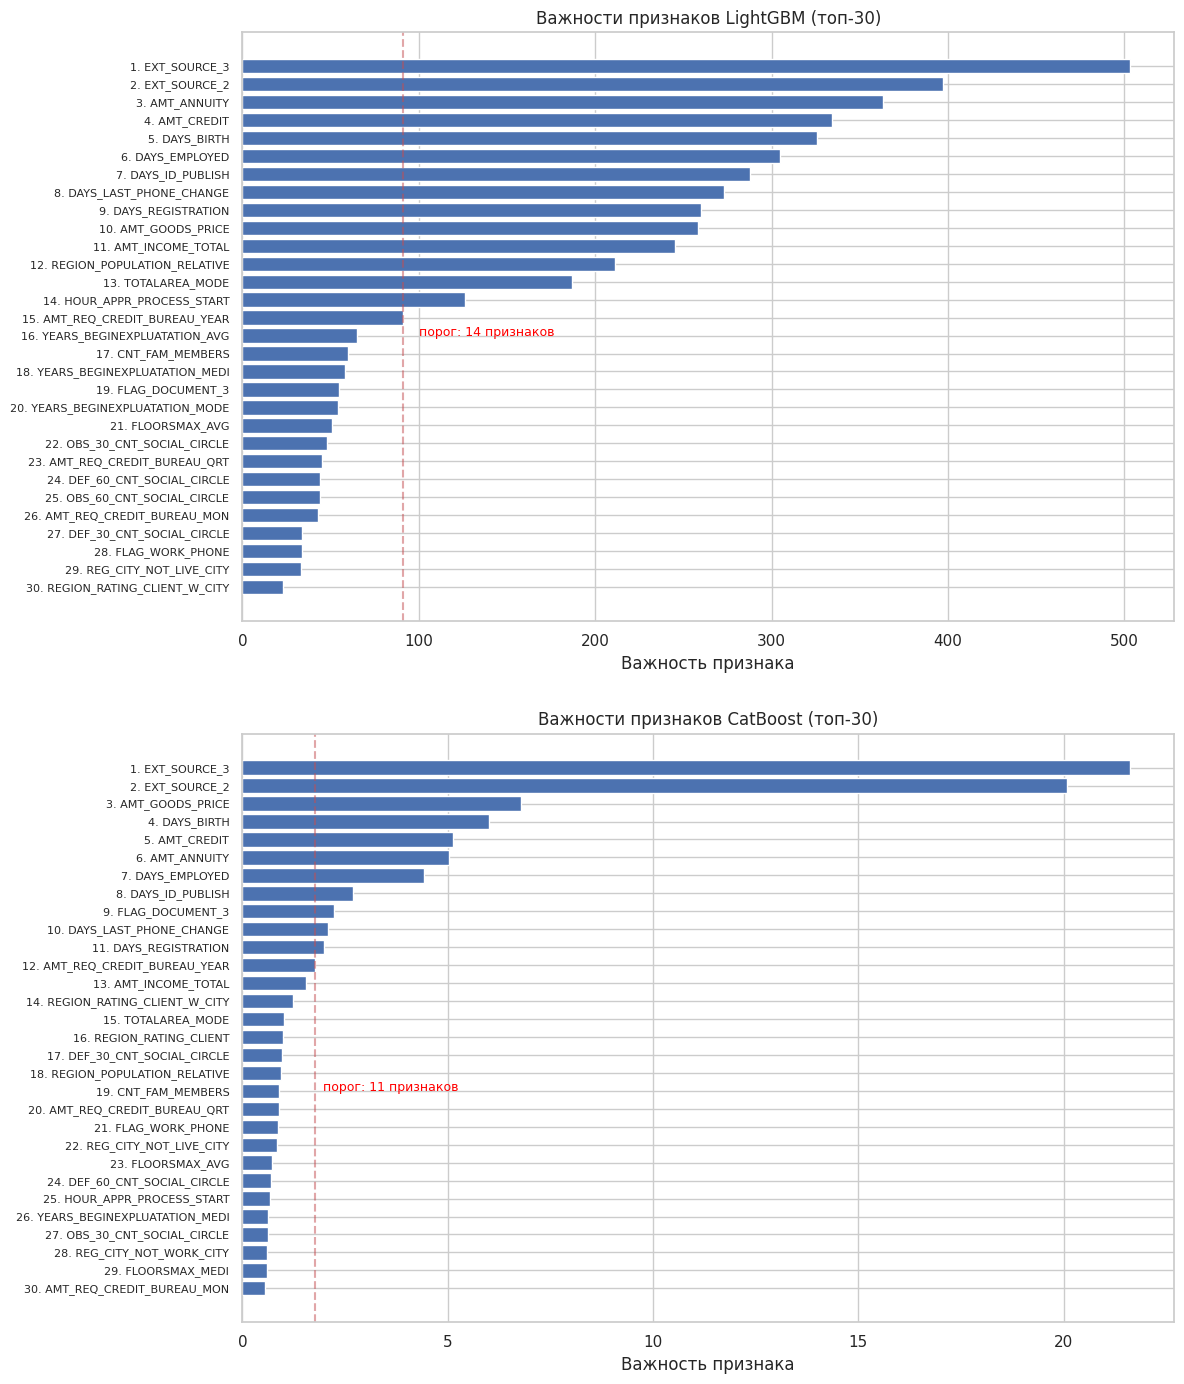


  LightGBM: выбрано 14 из 66 признаков
  CatBoost: выбрано 11 из 66 признаков
____________________________________________________________

  LightGBM выборки: train (179405, 14), test (76888, 14)
  CatBoost выборки: train (179405, 11), test (76888, 11)

  - Обучение LightGBM на "важных" признаках:
    Время обучения: 4.33 сек
    PR-AUC на тесте: 0.2233

  - Обучение CatBoost на "важных" признаках:
    Время обучения: 16.22 сек
    PR-AUC на тесте: 0.2241


In [15]:
# проверка наличия данных и создание копий
try:
    X_train_original = X_train_numeric.copy()
    X_test_original = X_test_numeric.copy()
    y_train_original = y_train.copy()
    y_test_original = y_test.copy()

    print(f"Данные скопированы: train {X_train_original.shape}, test {X_test_original.shape}")
except NameError:
    print("Данные не найдены")
    raise

# загрузка файлов сохранения из 3.3
try:
    lgb_best_model = joblib.load('lgb_best_model.pkl')
    cb_best_model = joblib.load('cb_best_model.pkl')
    print("Модели успешно загружены из файлов задания 3.3")
except Exception as e:
    print(f"Ошибка загрузки: {e}")
    print("Файлы моделей из задания 3.3 не найдены")
    raise

def evaluate_pr_auc(model, X_test, y_test):
    ''' функция для оценки PR-AUC '''
    y_pred = model.predict_proba(X_test)[:, 1]
    return average_precision_score(y_test, y_pred)

# исходные модели
lgb_original_pr_auc = evaluate_pr_auc(lgb_best_model, X_test_original, y_test_original)
cb_original_pr_auc = evaluate_pr_auc(cb_best_model, X_test_original, y_test_original)

print(f"\nLightGBM PR-AUC: {lgb_original_pr_auc:.4f}")
print(f"CatBoost PR-AUC: {cb_original_pr_auc:.4f}\n")



# получение и сортировка признаков по убыванию важности

  # LightGBM
lgb_importances = lgb_best_model.feature_importances_
lgb_feature_names = X_train_original.columns

lgb_sorted_idx = np.argsort(lgb_importances)[::-1]
lgb_sorted_names = lgb_feature_names[lgb_sorted_idx]
lgb_sorted_importances = lgb_importances[lgb_sorted_idx]

  # CatBoost
cb_importances = cb_best_model.feature_importances_
cb_feature_names = X_train_original.columns

cb_sorted_idx = np.argsort(cb_importances)[::-1]
cb_sorted_names = cb_feature_names[cb_sorted_idx]
cb_sorted_importances = cb_importances[cb_sorted_idx]

# визуализация
plt.figure(figsize=(12, 14))

  # LightGBM
plt.subplot(2, 1, 1)
n_show = 30
bars = plt.barh(range(n_show), lgb_sorted_importances[:n_show])

# подписи
labels = []
for i in range(n_show):
    feature_name = str(lgb_sorted_names[i])
    if len(feature_name) > 30:
        feature_name = feature_name[:27] + "..."
    labels.append(f"{i+1}. {feature_name}")

plt.yticks(range(n_show), labels, fontsize=8)
plt.xlabel('Важность признака')
plt.title(f'Важности признаков LightGBM (топ-{n_show})')
plt.gca().invert_yaxis()

# предполагаемый порог (на графике)
lgb_threshold_idx = 14
if lgb_threshold_idx < n_show:
    plt.axvline(x=lgb_sorted_importances[lgb_threshold_idx], color='r', linestyle='--', alpha=0.5)
    plt.text(lgb_sorted_importances[lgb_threshold_idx]*1.1, n_show-lgb_threshold_idx-1,
             f'порог: {lgb_threshold_idx} признаков', fontsize=9, color='red')

  # CatBoost
plt.subplot(2, 1, 2)
bars = plt.barh(range(n_show), cb_sorted_importances[:n_show])

# подписи
labels = []
for i in range(n_show):
    feature_name = str(cb_sorted_names[i])
    if len(feature_name) > 30:
        feature_name = feature_name[:27] + "..."
    labels.append(f"{i+1}. {feature_name}")

plt.yticks(range(n_show), labels, fontsize=8)
plt.xlabel('Важность признака')
plt.title(f'\nВажности признаков CatBoost (топ-{n_show})')
plt.gca().invert_yaxis()

# предполагаемый порог (на графике)
cb_threshold_idx = 11
if cb_threshold_idx < n_show:
    plt.axvline(x=cb_sorted_importances[cb_threshold_idx], color='r', linestyle='--', alpha=0.5)
    plt.text(cb_sorted_importances[cb_threshold_idx]*1.1, n_show-cb_threshold_idx-1,
             f'порог: {cb_threshold_idx} признаков', fontsize=9, color='red')

plt.tight_layout()
plt.show()

# отбор признаков по порогу
lgb_threshold_idx = 14
lgb_selected_features = lgb_sorted_names[:lgb_threshold_idx]

cb_threshold_idx = 11
cb_selected_features = cb_sorted_names[:cb_threshold_idx]

print(f"\n  LightGBM: выбрано {len(lgb_selected_features)} из {len(lgb_feature_names)} признаков")
print(f"  CatBoost: выбрано {len(cb_selected_features)} из {len(cb_feature_names)} признаков")

# новые выборки с отобранными признаками
X_train_lgb_selected = X_train_original[lgb_selected_features].copy()
X_test_lgb_selected = X_test_original[lgb_selected_features].copy()

X_train_cb_selected = X_train_original[cb_selected_features].copy()
X_test_cb_selected = X_test_original[cb_selected_features].copy()

print("_"*60 +"\n")
print(f"  LightGBM выборки: train {X_train_lgb_selected.shape}, test {X_test_lgb_selected.shape}")
print(f"  CatBoost выборки: train {X_train_cb_selected.shape}, test {X_test_cb_selected.shape}")

# обучение тех же модели на важных признаках
# Получаем параметры из исходных моделей
lgb_params = lgb_best_model.get_params()
cb_params = cb_best_model.get_params()

  # LightGBM
print('\n  - Обучение LightGBM на "важных" признаках:')
start_time = time.time()
lgb_new_model = lgb.LGBMClassifier(**lgb_params)
lgb_new_model.fit(X_train_lgb_selected, y_train_original)
lgb_new_time = time.time() - start_time
lgb_new_pr_auc = evaluate_pr_auc(lgb_new_model, X_test_lgb_selected, y_test_original)

print(f"    Время обучения: {lgb_new_time:.2f} сек")
print(f"    PR-AUC на тесте: {lgb_new_pr_auc:.4f}")

  # CatBoost
print('\n  - Обучение CatBoost на "важных" признаках:')
start_time = time.time()
cb_new_model = cb.CatBoostClassifier(**cb_params)
cb_new_model.fit(X_train_cb_selected, y_train_original)
cb_new_time = time.time() - start_time
cb_new_pr_auc = evaluate_pr_auc(cb_new_model, X_test_cb_selected, y_test_original)

print(f"    Время обучения: {cb_new_time:.2f} сек")
print(f"    PR-AUC на тесте: {cb_new_pr_auc:.4f}")


# # сохранение результатов (по желанию)
# joblib.dump(lgb_new_model, 'lgb_model_reduced.pkl')
# joblib.dump(cb_new_model, 'cb_model_reduced.pkl')

# print("  Модели с отобранными признаками сохранены в файлы:")
# print("    - lgb_model_reduced.pkl")
# print("    - cb_model_reduced.pkl")


In [17]:
# сравнение результатов
print("Сравнение:")
print("=" * 108)
print(f"{'Метод':<10} | {'Исход. признаков':<17} | {'Отобран. признаков':<17} | {'PR-AUC исход.':<12} | {'PR-AUC нов.':<10} | {'Разница':<8} | {'Изменение (%)':<12}")
print("-" * 108)

# LightGBM строка
lgb_diff = lgb_new_pr_auc - lgb_original_pr_auc
lgb_diff_percent = abs(lgb_diff) / lgb_original_pr_auc * 100 if lgb_original_pr_auc != 0 else 0
lgb_change = f"▼ -{lgb_diff_percent:.1f}%" if lgb_diff < 0 else f"▲ +{lgb_diff_percent:.1f}%" if lgb_diff > 0 else "0.0%"

print(f"{'LightGBM':<10} | {len(lgb_feature_names):<17} | {len(lgb_selected_features):<18} | {lgb_original_pr_auc:>13.4f} | {lgb_new_pr_auc:>11.4f} | {lgb_diff:>8.4f} | {lgb_change:>12}")

# CatBoost строка
cb_diff = cb_new_pr_auc - cb_original_pr_auc
cb_diff_percent = abs(cb_diff) / cb_original_pr_auc * 100 if cb_original_pr_auc != 0 else 0
cb_change = f"▼ -{cb_diff_percent:.1f}%" if cb_diff < 0 else f"▲ +{cb_diff_percent:.1f}%" if cb_diff > 0 else "0.0%"

print(f"{'CatBoost':<10} | {len(cb_feature_names):<17} | {len(cb_selected_features):<18} | {cb_original_pr_auc:>13.4f} | {cb_new_pr_auc:>11.4f} | {cb_diff:>8.4f} | {cb_change:>12}")
print("=" * 108)


# 10. Ответ на вопрос задания
print('\nПри удалении "неважных" признаков качество изменилось на:')
print(f"  - LightGBM:  {lgb_new_pr_auc - lgb_original_pr_auc:+.4f} ({abs(lgb_new_pr_auc - lgb_original_pr_auc)/lgb_original_pr_auc*100:.1f}%)")
print(f"  - CatBoost:  {cb_new_pr_auc - cb_original_pr_auc:+.4f} ({abs(cb_new_pr_auc - cb_original_pr_auc)/cb_original_pr_auc*100:.1f}%)")

print("\nКачество снизиось более, чем на 2% => признаки содержали ")
print("не только минимально полезную информацию для предсказания => ")
print("модели могут работать с существенно меньшим набором признаков,")
print("но отбор нужно производить очень точно")

Сравнение:
Метод      | Исход. признаков  | Отобран. признаков | PR-AUC исход. | PR-AUC нов. | Разница  | Изменение (%)
------------------------------------------------------------------------------------------------------------
LightGBM   | 66                | 14                 |        0.2283 |      0.2233 |  -0.0050 |      ▼ -2.2%
CatBoost   | 66                | 11                 |        0.2299 |      0.2241 |  -0.0058 |      ▼ -2.5%

При удалении "неважных" признаков качество изменилось на:
  - LightGBM:  -0.0050 (2.2%)
  - CatBoost:  -0.0058 (2.5%)

Качество снизиось более, чем на 2% => признаки содержали 
не только минимально полезную информацию для предсказания => 
модели могут работать с существенно меньшим набором признаков,
но отбор нужно производить очень точно
